# Margins
import astropy.units as u

LSDB can handle datasets larger than memory by breaking them down into smaller, spatially-connected parts and working on each part one at a time. One of the main tasks enabled by LSDB are spatial queries such as cross-matching; to ensure accurate comparisons, all nearby data points need to be loaded simultaneously. LSDB uses HATS' method of organizing data spatially to achieve this.

However, there's a limitation: at the boundaries of each divided section, some data points are going to be missed. This means that for operations requiring comparisons with neighboring points, such as cross-matching, the process might miss some matches for points near these boundaries because not all nearby points are included when analyzing one section at a time.

![Margin Boundary Example](_static/pixel-boundary-example.png)
*Here we see an example of a boundary between HEALPix pixels, where the green points are in one partition and the red points in another. Working with one partition at a time, we would miss potential matches with points close to the boundary*

To solve this, we could try to also load the neighboring partitions for each partition we crossmatch. However, this would require loading lots of unnecessary data, slowing down operations and causing issues with running out of memory. So, for each catalog, we also create a margin cache. This means that for each partition, we create a file that contains the points in the catalog within a certain distance to the pixel's boundary.

![Margin Cache Example](_static/margin-pix.png)
*An example of a margin cache (orange) for the same green pixel. The margin cache for this pixel contains the points within 10 arcseconds of the boundary.*

## Loading a Margin Catalog

The margin cache is stored as a separate HATS catalog with the same partitioning as the main catalog.

To load a catalog with a margin cache, we set the `margin_cache` parameter with the path of the catalog's margin catalog.


In [1]:
from astropy.coordinates import SkyCoord
import astropy.units as u
from hats.inspection import plot_pixel_list
from hats.pixel_math import HealpixPixel

import lsdb

surveys_path = "https://data.lsdb.io/hats/"

In [2]:
from lsdb import BoxSearch

box = BoxSearch(ra=(179.5, 180.001), dec=(9.4, 10))

ztf_object_path = f"{surveys_path}/ztf_dr14/ztf_object"
ztf_margin_path = f"{surveys_path}/ztf_dr14/ztf_object_10arcs"
ztf_object = lsdb.read_hats(
    ztf_object_path, search_filter=box, margin_cache=ztf_margin_path, columns=["ra", "dec"]
)
print(f"Margin size: {ztf_object.margin.hc_structure.catalog_info.margin_threshold} arcsec")
ztf_object.margin

Margin size: 10.0 arcsec


,ra,dec
npartitions=4,,
1945555039024054272,double[pyarrow],double[pyarrow]
1950058638651424768,...,...
1954562238278795264,...,...
1959065837906165760,...,...
1963569437533536256,...,...


Here we see the margin catalog that has been loaded with the catalog, using a margin threshold of 10 arcseconds.

Let's plot the catalog and its margin together:

(<Figure size 1000x500 with 1 Axes>,
 <WCSAxes: title={'center': 'Points in the ztf_dr14_10arcs catalog'}>)

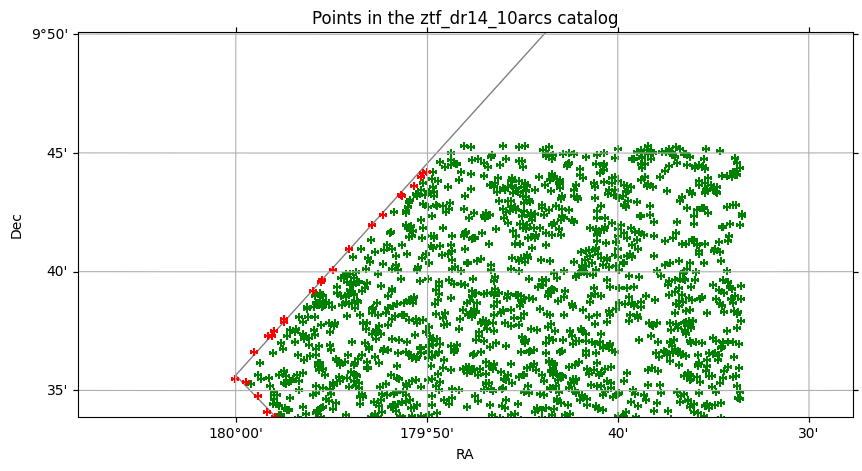

In [3]:
# the healpix pixel to plot
order = 3
pixel = 434

ztf_pixel = ztf_object.pixel_search([HealpixPixel(order, pixel)])

# Plot the points from the specified ztf pixel in green, and from the pixel's margin cache in red
ztf_pixel.plot_pixels(
    color_by_order=False, 
    fc="#00000000", 
    ec="grey",
    center=SkyCoord(179.8, 9.7, unit='deg'),
    fov=0.3 * u.deg,
)
ztf_pixel.plot_points(c="green", marker="+")
ztf_pixel.margin.plot_points(c="red", marker="+")

## Using the Margin Catalog

Performing operations like cross-matching and joining requires a margin to be loaded in the catalog on the right side of the operation. If this right catalog has been loaded with a margin, the function will be carried out accurately using the margin, and by default will throw an error if the margin has not been set. This can be overwritten using the `require_right_margin` parameter, but this may cause inaccurate results!

We can see this when trying to perform a crossmatch with gaia:

In [4]:
gaia = lsdb.read_hats(f"{surveys_path}/gaia_dr3/gaia/", columns=["ra", "dec"], search_filter=box)
gaia

,ra,dec
npartitions=1,,
1945555039024054272,double[pyarrow],double[pyarrow]
1963569437533536256,...,...


If we perform a crossmatch with gaia on the left and the ztf catalog we loaded with a margin on the right, the function works, and we get the result:

In [5]:
gaia.crossmatch(ztf_object)

,ra_gaia,dec_gaia,ra_ztf_dr14,dec_ztf_dr14,_dist_arcsec
npartitions=4,,,,,
1945555039024054272,double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow]
1950058638651424768,...,...,...,...,...
1954562238278795264,...,...,...,...,...
1959065837906165760,...,...,...,...,...
1963569437533536256,...,...,...,...,...


If we try the other way around, we have not loaded the right catalog (gaia) with a margin cache, and so we get an error.

In [6]:
try:
    ztf_object.crossmatch(gaia)
except ValueError as e:
    print(f"Error: {e}")

/Users/smcmu/code/lsdb/src/lsdb/dask/crossmatch_catalog_data.py:108: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


We can plot the result of the crossmatch below, with the gaia objects in green and the ztf objects in red.

(<Figure size 1000x500 with 1 Axes>,
 <WCSAxes: title={'center': 'Points in the gaia_x_ztf_dr14 catalog'}>)

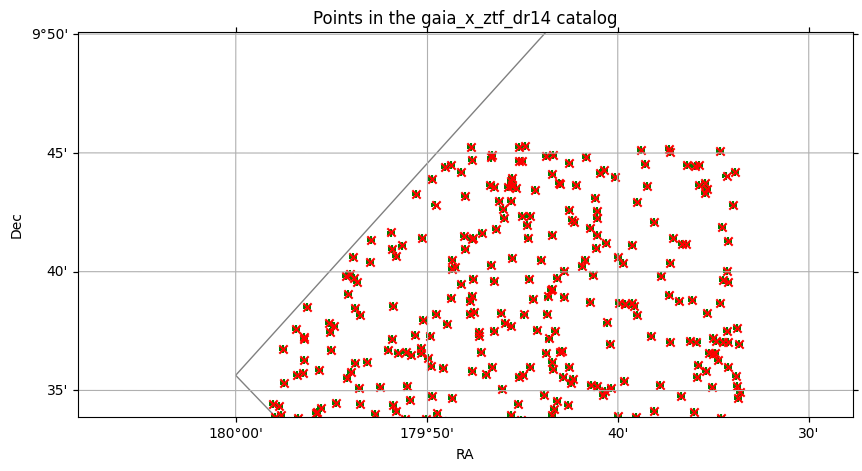

In [7]:
order = 3
pixel = 434

crossmatch_cat = gaia.crossmatch(ztf_pixel)

ztf_pixel.plot_pixels(
    color_by_order=False, 
    fc="#00000000", 
    ec="grey",
    center=SkyCoord(179.8, 9.7, unit='deg'),
    fov=0.3 * u.deg,
)
crossmatch_cat.plot_points(c="green", marker="+")
crossmatch_cat.plot_points(ra_column="ra_ztf_dr14", dec_column="dec_ztf_dr14", c="red", marker="x")

## Filtering Catalogs

Any filtering operations applied to the catalog are also performed to the margin.

(<Figure size 1000x500 with 1 Axes>,
 <WCSAxes: title={'center': 'Points in the ztf_dr14_10arcs catalog'}>)

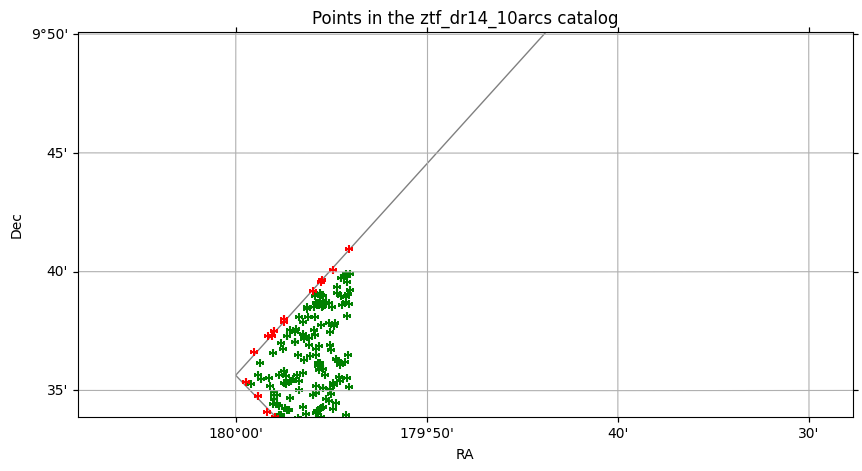

In [8]:
small_sky_box_filter = ztf_pixel.box_search(ra=[179.9, 180], dec=[9.5, 9.7])


# Plot the points from the specified ztf pixel in green, and from the pixel's margin cache in red
small_sky_box_filter.plot_pixels(
    color_by_order=False,
    fc="#00000000",
    ec="grey",
    center=SkyCoord(179.8, 9.7, unit='deg'),
    fov=0.3 * u.deg,
)
small_sky_box_filter.plot_points(c="green", marker="+")
small_sky_box_filter.margin.plot_points(c="red", marker="+")

## Avoiding Duplicates

Joining the margin cache to the catalog's data would introduce duplicate points, where points near the boundary would appear in both the margin of one partition and the main file of another partition. To avoid this, we keep two separate task graphs, one for the catalog and one for its margin.

For operations that don't require the margin, the task graphs remain separate, and when `compute` is called on the catalog, only the catalog's task graph is computed—without joining the margin or even loading the margin files.

For operations like crossmatching that require the margin, the task graphs are combined with the margin joined and used. For these operations, we use only the margin for the catalog on the right side of the operation. This means that for each left catalog point that is considered, all of the possible nearby matches in the right catalog are also loaded, so the results are kept accurate. But since there are no duplicates of the left catalog points, there are no duplicate results.